# TOPIC: FISH CLASSIFICATION DATASET

In [87]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/krish-vadhani/neural-project-ffdb3


'https://jovian.ai/krish-vadhani/neural-project-ffdb3'

In [3]:
dataset_url = 'https://www.kaggle.com/crowww/a-large-scale-fish-dataset/Fish_Dataset'

# Dataset Url from Kaggle

In [4]:
pip install opendatasets

In [5]:
import opendatasets as od

# Downloading the datasets

In [6]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: krishvadhani
Your Kaggle Key: ··········


100%|██████████| 3.24G/3.24G [00:49<00:00, 69.9MB/s]


In [7]:
import os

In [8]:
data_dir = './a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

In [9]:
os.listdir(data_dir)

['Red Mullet',
 'Trout',
 'README.txt',
 'Black Sea Sprat',
 'Red Sea Bream',
 'Hourse Mackerel',
 'Striped Red Mullet',
 'Gilt-Head Bream',
 'license.txt',
 'Segmentation_example_script.m',
 'Sea Bass',
 'Shrimp']

# Listing all the files from the directory

In [10]:
os.listdir(data_dir)

['Red Mullet',
 'Trout',
 'README.txt',
 'Black Sea Sprat',
 'Red Sea Bream',
 'Hourse Mackerel',
 'Striped Red Mullet',
 'Gilt-Head Bream',
 'license.txt',
 'Segmentation_example_script.m',
 'Sea Bass',
 'Shrimp']

# Importing all the necessary libraries

In [11]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split,DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
%matplotlib inline

In [18]:
dataset = ImageFolder(data_dir,tt.Compose([tt.Resize(192),
                                          tt.CenterCrop(192),
                                         tt.ToTensor()]))

In [19]:
len(dataset)

18000

In [20]:
dataset.classes

['Black Sea Sprat',
 'Gilt-Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [21]:
train_size = 16000
val_size = 2000

In [22]:
train_ds, val_ds = random_split(dataset,[train_size,val_size])

In [23]:
len(train_ds)

16000

# Understanding the dataset:
It is a images dataset with 18000 images of fish.

This dataset contains 9 different seafood types collected from a supermarket in Izmir, Turkey
for a university-industry collaboration project at Izmir University of Economics, and this work
was published in ASYU 2020.
The dataset includes:

gilt head bream, 

red sea bream, 

sea bass, 

red mullet, 

horse mackerel,

black sea sprat, 

striped red mullet, 

trout, 

shrimp

# Here we have to classify the images according to the 9 classes mentiones above.

# Loading the dataset into DataLoader

In [24]:
train_dl = DataLoader(train_ds,128,shuffle=True,num_workers=2,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
val_dl = DataLoader(val_ds,128,num_workers=2,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Loading some images from the dataset

torch.Size([3, 192, 192])
Label: Gilt-Head Bream


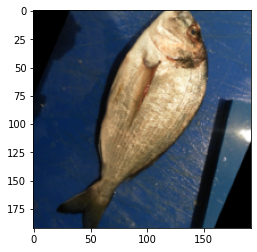

In [26]:
img, label = dataset[2299]
print(img.shape)
plt.imshow(img.permute(1,2,0))
print(f'Label:',dataset.classes[label])

In [27]:
def show_example(img,label):
  print('Label:',dataset.classes[label])
  plt.imshow(img.permute(1,2,0))

Label: Red Sea Bream


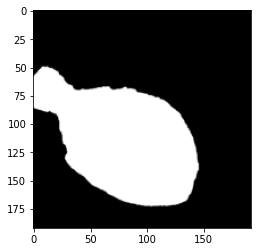

In [28]:
show_example(*dataset[9113])

# Loading a batch of images

In [29]:
def show_batch(train_dl):
  for img, label in train_dl:
    print(img.shape)
    plt.axis('off')
    plt.figure(figsize=(16,16))
    plt.imshow(make_grid(img, nrow=16).permute(1,2,0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 3, 192, 192])


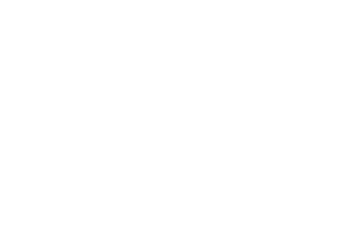

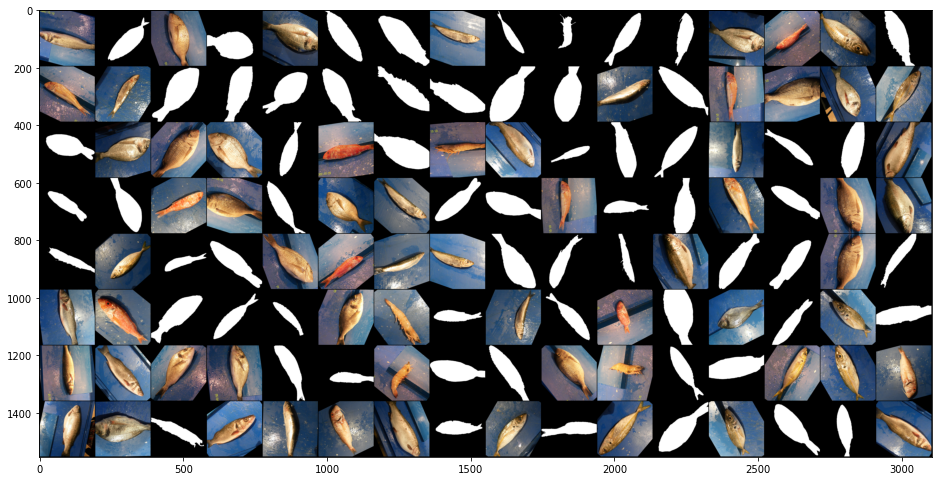

In [30]:
show_batch(train_dl)

# Model with Residual Blocks and Batch Normalization

# Defining the model using Resnet

Let's define the model by extending an ImageClassificationBase class which contains helper methods for training & validation.

In [31]:
def accuracy(out,label):
    _,pred = torch.max(out,dim=1)
    return torch.tensor(torch.sum(pred==label)/len(pred))

In [32]:
class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        img, label = batch
        out = self(img)
        loss = F.cross_entropy(out,label)
        return loss

    def validation_step(self,batch):
        img,label = batch
        out = self(img)
        loss = F.cross_entropy(out,label)
        acc = accuracy(out,label)
        return {'val_loss':loss,'val_acc':acc}

    def validation_epoch_end(self,out):
        val_loss = [x['val_loss'] for x in out]
        epoch_loss = torch.stack(val_loss).mean()

        val_acc = [x['val_acc'] for x in out]
        epoch_acc = torch.stack(val_acc).mean()

        return {'val_loss':epoch_loss,'val_acc':epoch_acc}

    def epoch_end(self,epoch,result):
        print('Epoch:[{}],val_loss:{},val_acc:{},train_loss:{}'.format(epoch,result['val_loss'],result['val_acc'],result['train_loss']))

# Setting up the GPU

We define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required

In [33]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [34]:
device = get_default_device()
device

device(type='cuda')

In [41]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

# We will use the ResNet9 architecture

In [42]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,3,kernel_size=3,stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(3,3,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        return out + x

In [43]:
simple_resnet = to_device(SimpleResidualBlock(),device)

for batch in train_dl:
    img, label = batch
    out = simple_resnet(img)
    print(out.shape)
    break

del simple_resnet, img, label
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 3, 192, 192])


In [44]:
def conv_block(in_channel,out_channel,pool=False):
    layers = [nn.Conv2d(in_channel,out_channel,kernel_size=3,padding=1,stride=1),
             nn.BatchNorm2d(out_channel),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [45]:
class Resnet9(ImageClassificationBase):
    def __init__(self,in_channel,num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channel,16)
        self.conv2 = conv_block(16,32,pool=True)
        self.res1 = nn.Sequential(conv_block(32,32),conv_block(32,32))
        
        self.conv3 = conv_block(32,64,pool=True)
        self.conv4 = conv_block(64,128,pool=True)
        self.res2 = nn.Sequential(conv_block(128,128),conv_block(128,128))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Dropout(0.2),
                                       nn.Linear(128*9*4,num_classes))
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        
        out = self.classifier(out)
        
        return out

In [46]:
model = to_device(Resnet9(3,9),device)
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

# Training the model

We'll define two functions: fit and evaluate to train the model using gradient descent and evaluate its performance on the validation set

In [47]:
@torch.no_grad()
def evaluate(model,val_dl):
  model.eval()
  out = [model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(out)

In [48]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [49]:
def fit(epochs,model,max_lr,train_dl,val_dl,weight_decay=0,grad_clip=None,opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(),max_lr)
    history = []
    torch.cuda.empty_cache()

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dl))

    for epoch in range(epochs):
        train_loss = []
        model.train()
        lrs = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model,val_dl)
        result['train_loss'] = torch.stack(train_loss).mean()
        result['lrs'] = lrs
        model.epoch_end(epoch,result)
        history.append(result)

    return history

In [50]:
hist = [evaluate(model,val_dl)]
hist

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


[{'val_acc': tensor(0.1226, device='cuda:0'),
  'val_loss': tensor(2.1973, device='cuda:0')}]

In [75]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [51]:
hist += fit(epochs,model,1e-2,train_dl,val_dl,weight_decay=weight_decay,opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch:[0],val_loss:20.515289306640625,val_acc:0.11513672024011612,train_loss:1.54439115524292
Epoch:[1],val_loss:11.56998062133789,val_acc:0.17783203721046448,train_loss:1.2018418312072754
Epoch:[2],val_loss:0.7211194038391113,val_acc:0.7154296636581421,train_loss:0.9636813402175903
Epoch:[3],val_loss:0.7276939153671265,val_acc:0.7289062738418579,train_loss:0.7145873308181763
Epoch:[4],val_loss:1.2039239406585693,val_acc:0.6351562738418579,train_loss:0.5959398746490479
Epoch:[5],val_loss:0.4694036841392517,val_acc:0.823925793170929,train_loss:0.4906719923019409
Epoch:[6],val_loss:0.3421815037727356,val_acc:0.876269519329071,train_loss:0.3978186249732971
Epoch:[7],val_loss:0.29832297563552856,val_acc:0.889941394329071,train_loss:0.31110286712646484
Epoch:[8],val_loss:0.2711217999458313,val_acc:0.897265613079071,train_loss:0.2579166889190674
Epoch:[9],val_loss:0.26309895515441895,val_acc:0.9024413824081421,train_loss:0.23372983932495117


# Here we get 90.24% accuracy

In [53]:
def plot_accuracies(history):
    acc = [x['val_acc'] for x in history]
    plt.plot(acc,'-rx')
    plt.xlabel = 'epoch'
    plt.ylabel = 'accuracy'
    plt.title = 'acc vs epoch'

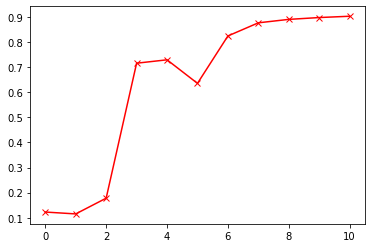

In [54]:
plot_accuracies(hist)

In [59]:
def plot_losses(history):
    loss = [x['val_loss'] for x in history]
    train_loss = [x.get('train_loss') for x in history]
    plt.plot(loss,'-bx')
    plt.plot(train_loss,'-rx')
    plt.xlabel = 'epoch'
    plt.ylabel = 'losses'
    plt.legend(['Validation','Training'])
    plt.title = 'losses vs epoch'

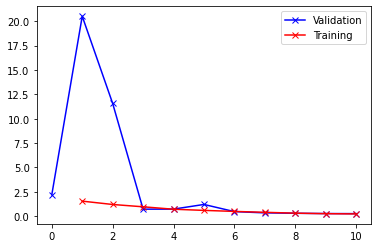

In [60]:
plot_losses(hist)

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs

In [64]:
import numpy as np

In [66]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel='Batch no.'
    plt.ylabel='Learning rate'
    plt.title='Learning Rate vs. Batch no.'

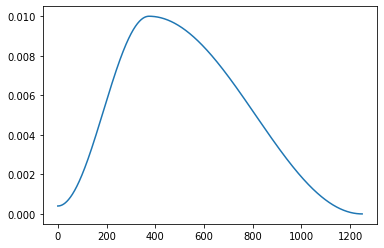

In [67]:
plot_lrs(hist)

# Testing with individual images

In [68]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0),device)
    yb = model(xb)
    _, pred = torch.max(yb,dim=1)
    return dataset.classes[pred[0].item()]

Label: Red Sea Bream Prediction: Red Sea Bream


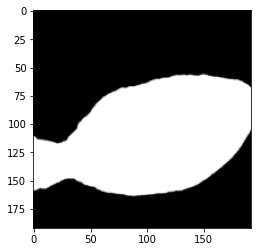

In [85]:
img, label = val_ds[703]
plt.imshow(img.permute(1,2,0))
print('Label:',dataset.classes[label],'Prediction:',predict_image(img,model))

Label: Gilt-Head Bream Prediction: Gilt-Head Bream


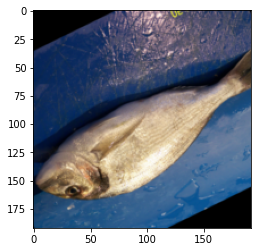

In [70]:
img, label = val_ds[922]
plt.imshow(img.permute(1,2,0))
print('Label:',dataset.classes[label],'Prediction:',predict_image(img,model))

Label: Shrimp Prediction: Shrimp


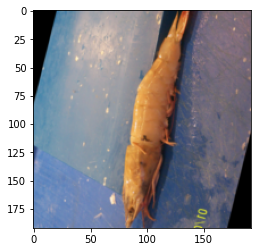

In [86]:
img, label = val_ds[67]
plt.imshow(img.permute(1,2,0))
print('Label:',dataset.classes[label],'Prediction:',predict_image(img,model))

# Saving Model Weights

In [76]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


# Conclusions

Here we conclude that on using CNN the accuracy was really poor 
but on using resnet the accuracy has improved drastically to more than 90%

To increase the accuracy make use of Centercrop while composing and not randomcrop which will crop the image from center

To increase the accuracy you can have more channels while performing resnet9 architecture like 1024 or more depending on RAM size 

# Therfore we have successfully performed classification of 18,000 images using Resnet Method